# 0. Initialization

## 0.1. Library imports

In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit_quantuminspire.qi_provider import QIProvider
import matplotlib.pyplot as plt
# from utility_functions import *
from scipy.optimize import curve_fit

## 0.2. Connecting to Quantum Inspire 2.0 backend provider

In [2]:
!qi login "https://api.quantum-inspire.com"

Please continue logging in by opening: https://auth.quantum-inspire.com/activate?user_code=CBLK-DNQF in your browser
If promped to verify a code, please confirm it is as follows: CBLK-DNQF
Login successful!
Using member ID 10


In [3]:
provider = QIProvider()

In [4]:
provider.backends()

[<qiskit_quantuminspire.qi_backend.QIBackend object at 0x174a13290 (name=QX emulator, id=1)>,
 <qiskit_quantuminspire.qi_backend.QIBackend object at 0x1739bc890 (name=Spin-2+, id=2)>,
 <qiskit_quantuminspire.qi_backend.QIBackend object at 0x17294b140 (name=Starmon-7, id=3)>]

# 1. Single-qubit experiments

## 1.1. Rabi oscillation

### 1.1.1. Experiment parameters

In [5]:
qubit_nr = 0 # e.g. the entry "0" is for qubit "Q0"
nr_shots = 5500 # number of shots per each measurement point
experiment_backend = "Starmon-7"

### 1.1.2. Experiment circuit

In [6]:
backend = provider.get_backend(name=experiment_backend)

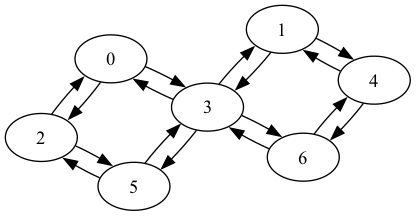

In [7]:
backend.coupling_map.draw()

In [6]:
backend = provider.get_backend(name=experiment_backend)
cycle_time = 20e-9 # cycle time of the Central Controller (CC) instrument
angle_step = np.pi / 28
total_steps = 56

qc = QuantumCircuit(2, total_steps) # NOTE: we should put backend.num_qubits here

for step_idx in range(total_steps):
    qc.delay(6000, qubit_nr)
    qc.rx(step_idx * angle_step, qubit_nr)
    qc.measure(qubit = qubit_nr, cbit = step_idx)

In [ ]:
qc.draw('mpl')

### 1.1.3. Run experiment

In [ ]:
job = backend.run(qc, shots=nr_shots, memory = True)
result = job.result(timeout = 600) # get the results

### 1.1.4. Experiment data processing

In [8]:
raw_data_prob = get_raw_data_prob(qc, result)

In [9]:
prob_state_1 = []
for entry in range(len(raw_data_prob)):
    prob_state_1.append(raw_data_prob[entry]['prob(1)'])

In [ ]:
def cos_func(x, a, b, c, d):
    return a * np.cos(2*np.pi*b*x + c) + d
params, covariance = curve_fit(cos_func, np.arange(0, total_steps, 1), prob_state_1)
a_fit, b_fit, c_fit, d_fit = params
cosine_fit = cos_func(np.arange(0, total_steps, 1), a_fit, b_fit, c_fit, d_fit)

fig, ax = plt.subplots(figsize=(18, 5))
ax.scatter(np.arange(0, total_steps, 1), prob_state_1, label='Data')
ax.plot(np.arange(0, total_steps, 1), cosine_fit, label='cos() fit', color='r')
ax.set_xlabel('Applied pulse')
ax.set_ylabel(r'$F$ $|1 \rangle$')
ax.set_title(f'Rabi oscillation\nQubit "{qubit_nr}"')

labels = []
for step_idx in range(total_steps):
    angle_in_degrees = (360 / (2 * np.pi)) * step_idx * angle_step
    step_label = f"rx{round(angle_in_degrees)}"
    labels.append(step_label)
label_locs = np.arange(0, total_steps, 1)
ax.set_xticks(label_locs)
ax.set_xticklabels(labels, rotation=65)
ax.set_ylim(-0.05, 1.05)

plt.grid()
plt.legend()
plt.show()

## 1.2. T1 measurement

### 1.2.1. Experiment parameters

In [10]:
qubit_nr = 0 # e.g. the entry "0" is for qubit "Q0"
total_time = 150e-6 # in units of [s]
nr_points = 31 # number of measurement points
nr_shots = 2**16 # number of shots per each measurement point
experiment_backend = "Starmon 7"

### 1.2.2. Experiment circuit

In [11]:
backend = provider.get_backend(name=experiment_backend)
cycle_time = 20e-9 # cycle time of the Central Controller (CC) instrument
dt = total_time / nr_points
measurement_times = np.linspace(start = 0.0, stop = total_time, num = nr_points)

qc = QuantumCircuit(7, nr_points) # NOTE: we should put backend.num_qubits here
qc.x(qubit_nr) # qubit initialization to the |1> state
qc.measure(qubit = qubit_nr, cbit = 0) # initial measurement at time t=0
for time_idx in range(1, nr_points):
    qc.delay(duration = int((dt / cycle_time)), qarg = qubit_nr) # delay in units of CC cycles
    qc.measure(qubit = qubit_nr, cbit = time_idx)

In [ ]:
qc.draw('mpl')

### 1.2.3. Run experiment

In [12]:
job = backend.run(qc, shots=nr_shots, memory = True)
result = job.result(timeout = 600) # get the results

### 1.2.4. Experiment data processing

In [13]:
raw_data_prob = get_raw_data_prob(qc, result)

In [14]:
prob_state_1 = []
for entry in range(len(raw_data_prob)):
    prob_state_1.append(raw_data_prob[entry]['prob(1)'])

In [ ]:
def exponential_func(x, a, b):
    return a * np.exp(b*x)
params, covariance = curve_fit(exponential_func, measurement_times, prob_state_1)
a_fit, b_fit = params
exponential_fit = exponential_func(measurement_times, a_fit, b_fit)

fig, ax = plt.subplots()
ax.scatter(1e6*measurement_times, prob_state_1, label='Data')
ax.plot(1e6*measurement_times, exponential_fit, label='exp() fit', color='r')
ax.set_xlabel('Time [μs]')
ax.set_ylabel(r'$F$ $|1 \rangle$')
ax.set_title(f'T1 measurement\nQubit "{qubit_nr}"')

ax.text(x = 0.0, y = 0.0, s = f'T1 = {- 1e6 * 1 / b_fit:.2f} μs',
        bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 5})
ax.set_ylim(-0.05, 1.05)

plt.legend()
plt.show()

## 1.3. T2 Ramsey measurement

### 1.3.1. Experiment parameters

In [16]:
qubit_nr = 0 # e.g. the entry "0" is for qubit "Q0"
total_time = 60e-6 # in units of [s]
nr_points = 51 # number of measurement points
nr_shots = 2**12 # number of shots per each measurement point
experiment_backend = "Starmon 7"

### 1.3.2. Experiment circuit

In [17]:
backend = provider.get_backend(name=experiment_backend)
cycle_time = 20e-9 # cycle time of the Central Controller (CC) instrument
dt = total_time / nr_points
measurement_times = np.linspace(start = 0.0, stop = total_time, num = nr_points)

artificial_detuning = 5 / measurement_times[-1] # borrowed from PycQED

qc = QuantumCircuit(7, nr_points) # NOTE: we should put backend.num_qubits here

for time_idx in range(nr_points):
    qc.delay(6000, qubit_nr)
    qc.rx(np.pi / 2, qubit_nr)
    qc.delay(duration = time_idx * int((dt / cycle_time)), qarg = qubit_nr) # delay in units of CC cycles
    qc.rz(-2*np.pi*artificial_detuning*time_idx*dt, qubit_nr)
    qc.rx(np.pi / 2, qubit_nr)

    qc.measure(qubit = qubit_nr, cbit = time_idx)

In [ ]:
qc.draw('mpl')

### 1.3.3. Run experiment

In [18]:
job = backend.run(qc, shots=nr_shots, memory = True)
result = job.result(timeout = 600) # get the results

### 1.3.4. Experiment data processing

In [22]:
raw_data_prob = get_raw_data_prob(qc, result)

In [23]:
prob_state_1 = []
for entry in range(len(raw_data_prob)):
    prob_state_1.append(raw_data_prob[entry]['prob(1)'])

In [ ]:
def exp_damp_osc_func(x, a, b, c, d, e):
    return a * np.exp(b*x) * np.cos(c*x + d) + e

params, covariance = curve_fit(exp_damp_osc_func, measurement_times, prob_state_1)

a_fit, b_fit, c_fit, d_fit, e_fit = params
exponential_fit = exp_damp_osc_func(measurement_times, a_fit, b_fit, c_fit,
                                    d_fit, e_fit)

fig, ax = plt.subplots()
ax.scatter(1e6*measurement_times, prob_state_1, label='Data')
ax.plot(1e6*measurement_times, exponential_fit, label='exp()cos() fit', color='r')
ax.set_xlabel('Time [μs]')
ax.set_ylabel(r'$F$ $|1 \rangle$')
ax.set_ylim(0.0)
ax.set_title(f'T2 Ramsey measurement\nQubit "{qubit_nr}"')

ax.text(x = 0.0, y = 0.05, s = f'T2* = {- 1e6 * 1 / b_fit:.2f} μs',
        bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 5})
ax.set_ylim(-0.05, 1.05)

plt.legend()
plt.show()

## 1.4. T2 Echo measurement

### 1.4.1. Experiment parameters

In [25]:
qubit_nr = 0 # e.g. the entry "0" is for qubit "Q0"
total_time = 60e-6 # in units of [s]
nr_points = 51 # number of measurement points
nr_shots = 2**12 # number of shots per each measurement point
experiment_backend = "Starmon 7"

### 1.4.2. Experiment circuit

In [26]:
backend = provider.get_backend(name=experiment_backend)
cycle_time = 20e-9 # cycle time of the Central Controller (CC) instrument
dt = total_time / nr_points
measurement_times = np.linspace(start = 0.0, stop = total_time, num = nr_points)

artificial_detuning = 5 / measurement_times[-1] # borrowed from PycQED

qc = QuantumCircuit(7, nr_points) # NOTE: we should put backend.num_qubits here

for time_idx in range(nr_points):
    qc.delay(6000, qubit_nr)
    qc.rx(np.pi / 2, qubit_nr)
    qc.delay(duration = time_idx * int((dt / cycle_time) / 2), qarg = qubit_nr) # delay in units of CC cycles
    qc.x(qubit_nr)
    qc.delay(duration = time_idx * int((dt / cycle_time) / 2), qarg = qubit_nr) # delay in units of CC cycles
    qc.rz(-2*np.pi*artificial_detuning*time_idx*dt, qubit_nr)
    qc.rx(np.pi / 2, qubit_nr)

    qc.measure(qubit = qubit_nr, cbit = time_idx)

In [ ]:
qc.draw('mpl')

### 1.4.3. Run experiment

In [27]:
job = backend.run(qc, shots=nr_shots, memory = True)
result = job.result(timeout = 600) # get the results

### 1.4.4. Experiment data processing

In [28]:
raw_data_prob = get_raw_data_prob(qc, result)

In [29]:
prob_state_1 = []
for entry in range(len(raw_data_prob)):
    prob_state_1.append(raw_data_prob[entry]['prob(1)'])

In [ ]:
def exp_damp_osc_func(x, a, b, c, d, e):
    return a * np.exp(b*x) * np.cos(c*x + d) + e

params, covariance = curve_fit(exp_damp_osc_func, measurement_times, prob_state_1)

a_fit, b_fit, c_fit, d_fit, e_fit = params
exponential_fit = exp_damp_osc_func(measurement_times, a_fit, b_fit, c_fit,
                                    d_fit, e_fit)

fig, ax = plt.subplots()
ax.scatter(1e6*measurement_times, prob_state_1, label='Data')
ax.plot(1e6*measurement_times, exponential_fit, label='exp()cos() fit', color='r')
ax.set_xlabel('Time [μs]')
ax.set_ylabel(r'$F$ $|1 \rangle$')
ax.set_ylim(0.0)
ax.set_title(f'T2 Echo measurement\nQubit "{qubit_nr}"')

ax.text(x = 0.0, y = 0.95, s = f'T2 echo = {- 1e6 * 1 / b_fit:.2f} μs',
        bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 5})
ax.set_ylim(-0.05, 1.05)

plt.legend()
plt.show()

## 1.5. Flipping measurement

### 1.5.1. Experiment parameters

In [31]:
qubit_nr = 0 # e.g. the entry "0" is for qubit "Q0"
nr_shots = 2**19 # number of shots per each measurement point
experiment_backend = "Starmon 7"

### 1.5.2. Experiment circuit

In [32]:
backend = provider.get_backend(name=experiment_backend)
cycle_time = 20e-9 # cycle time of the Central Controller (CC) instrument
number_of_flips = np.arange(0, 31, 2)

qc = QuantumCircuit(7, len(number_of_flips)) # NOTE: we should put backend.num_qubits here
bit_index = 0

for flip_nr in number_of_flips:
    qc.delay(6000, qubit_nr)
    qc.rx(np.pi/2, qubit_nr)

    for flip_idx in range(flip_nr):
        qc.x(qubit_nr)
    qc.measure(qubit = qubit_nr, cbit = bit_index)
    bit_index += 1

In [ ]:
qc.draw('mpl')

### 1.5.3. Run experiment

In [33]:
job = backend.run(qc, shots=nr_shots, memory = True)
result = job.result(timeout = 600) # get the results

### 1.5.4. Experiment data processing

In [34]:
raw_data_prob = get_raw_data_prob(qc, result)

In [35]:
prob_state_1 = []
for entry in range(len(raw_data_prob)):
    prob_state_1.append(raw_data_prob[entry]['prob(1)'])

In [ ]:
ideal_data = 0.5*np.ones(16)
data_error = prob_state_1 - ideal_data

deviation_total = np.mean(abs(data_error))

fig, ax = plt.subplots()
ax.scatter(number_of_flips, prob_state_1, label='Data')
ax.plot(number_of_flips, prob_state_1, alpha=0.7)
ax.plot(number_of_flips, ideal_data, label='Ideal', color='orange')
ax.set_xlabel(r"Number of (effective) $\pi$ pulses")
ax.set_ylabel(r'$F$ $|1 \rangle$')
ax.set_title(f'Flipping measurement rx180\nQubit "{qubit_nr}"')

ax.text(x = 1.0, y = 0.95, s = f'Deviation: {deviation_total:.3}',
        bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 5})
ax.set_ylim(-0.05, 1.05)

plt.legend()
plt.show()

## 1.6. AllXY measurement

### 1.6.1. Experiment parameters

In [37]:
qubit_nr = 0 # e.g. the entry "0" is for qubit "Q0"
nr_shots = 7000 # number of shots per each measurement point
experiment_backend = "Starmon 7"

### 1.6.2. Experiment circuit

In [38]:
backend = provider.get_backend(name=experiment_backend)

qc = QuantumCircuit(7, 42) # NOTE: we should put backend.num_qubits here
bit_index = 0

for i in range(2):
    qc.delay(6000, qubit_nr)
    qc.id(qubit_nr)
    qc.id(qubit_nr)
    qc.measure(qubit_nr, cbit = bit_index)
    bit_index += 1

for i in range(2):
    qc.delay(6000, qubit_nr)
    qc.x(qubit_nr)
    qc.x(qubit_nr)
    qc.measure(qubit_nr, cbit = bit_index)
    bit_index += 1

for i in range(2):
    qc.delay(6000, qubit_nr)
    qc.y(qubit_nr)
    qc.y(qubit_nr)
    qc.measure(qubit_nr, cbit = bit_index)
    bit_index += 1

for i in range(2):
    qc.delay(6000, qubit_nr)
    qc.x(qubit_nr)
    qc.y(qubit_nr)
    qc.measure(qubit_nr, cbit = bit_index)
    bit_index += 1

for i in range(2):
    qc.delay(6000, qubit_nr)
    qc.y(qubit_nr)
    qc.x(qubit_nr)
    qc.measure(qubit_nr, cbit = bit_index)
    bit_index += 1

for i in range(2):
    qc.delay(6000, qubit_nr)
    qc.rx(np.pi/2, qubit_nr)
    qc.id(qubit_nr)
    qc.measure(qubit_nr, cbit = bit_index)
    bit_index += 1

for i in range(2):
    qc.delay(6000, qubit_nr)
    qc.ry(np.pi/2, qubit_nr)
    qc.id(qubit_nr)
    qc.measure(qubit_nr, cbit = bit_index)
    bit_index += 1

for i in range(2):
    qc.delay(6000, qubit_nr)
    qc.rx(np.pi/2, qubit_nr)
    qc.ry(np.pi/2, qubit_nr)
    qc.measure(qubit_nr, cbit = bit_index)
    bit_index += 1

for i in range(2):
    qc.delay(6000, qubit_nr)
    qc.ry(np.pi/2, qubit_nr)
    qc.rx(np.pi/2, qubit_nr)
    qc.measure(qubit_nr, cbit = bit_index)
    bit_index += 1

for i in range(2):
    qc.delay(6000, qubit_nr)
    qc.rx(np.pi/2, qubit_nr)
    qc.y(qubit_nr)
    qc.measure(qubit_nr, cbit = bit_index)
    bit_index += 1

for i in range(2):
    qc.delay(6000, qubit_nr)
    qc.ry(np.pi/2, qubit_nr)
    qc.x(qubit_nr)
    qc.measure(qubit_nr, cbit = bit_index)
    bit_index += 1

for i in range(2):
    qc.delay(6000, qubit_nr)
    qc.x(qubit_nr)
    qc.ry(np.pi/2, qubit_nr)
    qc.measure(qubit_nr, cbit = bit_index)
    bit_index += 1

for i in range(2):
    qc.delay(6000, qubit_nr)
    qc.y(qubit_nr)
    qc.rx(np.pi/2, qubit_nr)
    qc.measure(qubit_nr, cbit = bit_index)
    bit_index += 1

for i in range(2):
    qc.delay(6000, qubit_nr)
    qc.rx(np.pi/2, qubit_nr)
    qc.x(qubit_nr)
    qc.measure(qubit_nr, cbit = bit_index)
    bit_index += 1

for i in range(2):
    qc.delay(6000, qubit_nr)
    qc.x(qubit_nr)
    qc.rx(np.pi/2, qubit_nr)
    qc.measure(qubit_nr, cbit = bit_index)
    bit_index += 1

for i in range(2):
    qc.delay(6000, qubit_nr)
    qc.ry(np.pi/2, qubit_nr)
    qc.y(qubit_nr)
    qc.measure(qubit_nr, cbit = bit_index)
    bit_index += 1

for i in range(2):
    qc.delay(6000, qubit_nr)
    qc.y(qubit_nr)
    qc.ry(np.pi/2, qubit_nr)
    qc.measure(qubit_nr, cbit = bit_index)
    bit_index += 1

for i in range(2):
    qc.delay(6000, qubit_nr)
    qc.x(qubit_nr)
    qc.id(qubit_nr)
    qc.measure(qubit_nr, cbit = bit_index)
    bit_index += 1

for i in range(2):
    qc.delay(6000, qubit_nr)
    qc.y(qubit_nr)
    qc.id(qubit_nr)
    qc.measure(qubit_nr, cbit = bit_index)
    bit_index += 1

for i in range(2):
    qc.delay(6000, qubit_nr)
    qc.rx(np.pi/2, qubit_nr)
    qc.rx(np.pi/2, qubit_nr)
    qc.measure(qubit_nr, cbit = bit_index)
    bit_index += 1

for i in range(2):
    qc.delay(6000, qubit_nr)
    qc.ry(np.pi/2, qubit_nr)
    qc.ry(np.pi/2, qubit_nr)
    qc.measure(qubit_nr, cbit = bit_index)
    bit_index += 1

In [ ]:
qc.draw('mpl')

### 1.6.3. Run experiment

In [39]:
job = backend.run(qc, shots=nr_shots, memory = True)
result = job.result(timeout = 600) # get the results

### 1.6.4. Experiment data processing

In [40]:
raw_data_prob = get_raw_data_prob(qc, result)

In [41]:
prob_state_1 = []
for entry in range(len(raw_data_prob)):
    prob_state_1.append(raw_data_prob[entry]['prob(1)'])

In [ ]:
ideal_data = np.concatenate((0*np.ones(10), 0.5*np.ones(24), np.ones(8)))
data_error = prob_state_1 - ideal_data

deviation_total = np.mean(abs(data_error))

fig, ax = plt.subplots()
ax.scatter(np.linspace(1, 43, 42), prob_state_1, label='Measurement')
ax.plot(np.linspace(1, 43, 42), prob_state_1)
ax.plot(np.linspace(1, 43, 42), ideal_data, label='Ideal', color='orange')
ax.set_ylabel(r'$F$ $|1 \rangle$')
ax.set_ylim(-0.1, 1.1)
ax.set_title(f'AllXY measurement\nQubit "{qubit_nr}"')

label_locs = np.arange(2, 43, 2)
labels = ['II', 'XX', 'YY', 'XY', 'YX',
          'xI', 'yI', 'xy', 'yx', 'xY', 'yX',
          'Xy', 'Yx', 'xX', 'Xx', 'yY', 'Yy',
          'XI', 'YI', 'xx', 'yy']
ax.set_xticks(label_locs)
ax.set_xticklabels(labels, rotation=60)

ax.text(x = 1.0, y = 1.0, s = f'Deviation: {deviation_total:.3}',
        bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 5})

plt.legend(loc="lower right")
plt.show()

# 2. Two-qubit experiments

## 2.1. Simultaneous 2Q AllXY measurement

### 2.1.1. Experiment parameters

In [69]:
qubit_0 = 1 # e.g. the entry "0" is for qubit "Q0"
qubit_1 = 4
nr_shots = 7000 # number of shots per each measurement point
experiment_backend = "Starmon 7"

### 2.1.2. Experiment circuit

In [70]:
backend = provider.get_backend(name=experiment_backend)

qc = QuantumCircuit(7, 84) # NOTE: we should put backend.num_qubits here
bit_index = 0

for i in range(2):
    qc.delay(6000, qubit_0)
    qc.delay(6000, qubit_1)

    qc.id(qubit_0)
    qc.id(qubit_0)
    qc.id(qubit_1)
    qc.id(qubit_1)

    qc.measure(qubit_0, cbit = bit_index)
    qc.measure(qubit_1, cbit = bit_index+42)
    bit_index += 1

    qc.barrier()


for i in range(2):
    qc.delay(6000, qubit_0)
    qc.delay(6000, qubit_1)

    qc.x(qubit_0)
    qc.x(qubit_0)
    qc.x(qubit_1)
    qc.x(qubit_1)

    qc.measure(qubit_0, cbit = bit_index)
    qc.measure(qubit_1, cbit = bit_index+42)

    bit_index += 1

    qc.barrier()

for i in range(2):
    qc.delay(6000, qubit_0)
    qc.delay(6000, qubit_1)

    qc.y(qubit_0)
    qc.y(qubit_0)
    qc.y(qubit_1)
    qc.y(qubit_1)

    qc.measure(qubit_0, cbit = bit_index)
    qc.measure(qubit_1, cbit = bit_index+42)

    bit_index += 1

    qc.barrier()

for i in range(2):
    qc.delay(6000, qubit_0)
    qc.delay(6000, qubit_1)

    qc.x(qubit_0)
    qc.y(qubit_0)
    qc.x(qubit_1)
    qc.y(qubit_1)

    qc.measure(qubit_0, cbit = bit_index)
    qc.measure(qubit_1, cbit = bit_index+42)

    bit_index += 1

    qc.barrier()

for i in range(2):
    qc.delay(6000, qubit_0)
    qc.delay(6000, qubit_1)

    qc.y(qubit_0)
    qc.x(qubit_0)
    qc.y(qubit_1)
    qc.x(qubit_1)

    qc.measure(qubit_0, cbit = bit_index)
    qc.measure(qubit_1, cbit = bit_index+42)

    bit_index += 1

    qc.barrier()

for i in range(2):
    qc.delay(6000, qubit_0)
    qc.delay(6000, qubit_1)

    qc.rx(np.pi/2, qubit_0)
    qc.id(qubit_0)
    qc.rx(np.pi/2, qubit_1)
    qc.id(qubit_1)

    qc.measure(qubit_0, cbit = bit_index)
    qc.measure(qubit_1, cbit = bit_index+42)

    bit_index += 1

    qc.barrier()

for i in range(2):
    qc.delay(6000, qubit_0)
    qc.delay(6000, qubit_1)

    qc.ry(np.pi/2, qubit_0)
    qc.id(qubit_0)
    qc.ry(np.pi/2, qubit_1)
    qc.id(qubit_1)

    qc.measure(qubit_0, cbit = bit_index)
    qc.measure(qubit_1, cbit = bit_index+42)

    bit_index += 1

    qc.barrier()

for i in range(2):
    qc.delay(6000, qubit_0)
    qc.delay(6000, qubit_1)

    qc.rx(np.pi/2, qubit_0)
    qc.ry(np.pi/2, qubit_0)
    qc.rx(np.pi/2, qubit_1)
    qc.ry(np.pi/2, qubit_1)

    qc.measure(qubit_0, cbit = bit_index)
    qc.measure(qubit_1, cbit = bit_index+42)

    bit_index += 1

    qc.barrier()

for i in range(2):
    qc.delay(6000, qubit_0)
    qc.delay(6000, qubit_1)

    qc.ry(np.pi/2, qubit_0)
    qc.rx(np.pi/2, qubit_0)
    qc.ry(np.pi/2, qubit_1)
    qc.rx(np.pi/2, qubit_1)

    qc.measure(qubit_0, cbit = bit_index)
    qc.measure(qubit_1, cbit = bit_index+42)

    bit_index += 1

    qc.barrier()

for i in range(2):
    qc.delay(6000, qubit_0)
    qc.delay(6000, qubit_1)

    qc.rx(np.pi/2, qubit_0)
    qc.y(qubit_0)
    qc.rx(np.pi/2, qubit_1)
    qc.y(qubit_1)

    qc.measure(qubit_0, cbit = bit_index)
    qc.measure(qubit_1, cbit = bit_index+42)

    bit_index += 1

    qc.barrier()

for i in range(2):
    qc.delay(6000, qubit_0)
    qc.delay(6000, qubit_1)

    qc.ry(np.pi/2, qubit_0)
    qc.x(qubit_0)
    qc.ry(np.pi/2, qubit_1)
    qc.x(qubit_1)

    qc.measure(qubit_0, cbit = bit_index)
    qc.measure(qubit_1, cbit = bit_index+42)

    bit_index += 1

    qc.barrier()

for i in range(2):
    qc.delay(6000, qubit_0)
    qc.delay(6000, qubit_1)

    qc.x(qubit_0)
    qc.ry(np.pi/2, qubit_0)
    qc.x(qubit_1)
    qc.ry(np.pi/2, qubit_1)

    qc.measure(qubit_0, cbit = bit_index)
    qc.measure(qubit_1, cbit = bit_index+42)

    bit_index += 1

    qc.barrier()

for i in range(2):
    qc.delay(6000, qubit_0)
    qc.delay(6000, qubit_1)

    qc.y(qubit_0)
    qc.rx(np.pi/2, qubit_0)
    qc.y(qubit_1)
    qc.rx(np.pi/2, qubit_1)

    qc.measure(qubit_0, cbit = bit_index)
    qc.measure(qubit_1, cbit = bit_index+42)

    bit_index += 1

    qc.barrier()

for i in range(2):
    qc.delay(6000, qubit_0)
    qc.delay(6000, qubit_1)

    qc.rx(np.pi/2, qubit_0)
    qc.x(qubit_0)
    qc.rx(np.pi/2, qubit_1)
    qc.x(qubit_1)

    qc.measure(qubit_0, cbit = bit_index)
    qc.measure(qubit_1, cbit = bit_index+42)

    bit_index += 1

    qc.barrier()

for i in range(2):
    qc.delay(6000, qubit_0)
    qc.delay(6000, qubit_1)

    qc.x(qubit_0)
    qc.rx(np.pi/2, qubit_0)
    qc.x(qubit_1)
    qc.rx(np.pi/2, qubit_1)

    qc.measure(qubit_0, cbit = bit_index)
    qc.measure(qubit_1, cbit = bit_index+42)

    bit_index += 1

    qc.barrier()

for i in range(2):
    qc.delay(6000, qubit_0)
    qc.delay(6000, qubit_1)

    qc.ry(np.pi/2, qubit_0)
    qc.y(qubit_0)
    qc.ry(np.pi/2, qubit_1)
    qc.y(qubit_1)

    qc.measure(qubit_0, cbit = bit_index)
    qc.measure(qubit_1, cbit = bit_index+42)

    bit_index += 1

    qc.barrier()

for i in range(2):
    qc.delay(6000, qubit_0)
    qc.delay(6000, qubit_1)

    qc.y(qubit_0)
    qc.ry(np.pi/2, qubit_0)
    qc.y(qubit_1)
    qc.ry(np.pi/2, qubit_1)

    qc.measure(qubit_0, cbit = bit_index)
    qc.measure(qubit_1, cbit = bit_index+42)

    bit_index += 1

    qc.barrier()

for i in range(2):
    qc.delay(6000, qubit_0)
    qc.delay(6000, qubit_1)

    qc.x(qubit_0)
    qc.id(qubit_0)
    qc.x(qubit_1)
    qc.id(qubit_1)

    qc.measure(qubit_0, cbit = bit_index)
    qc.measure(qubit_1, cbit = bit_index+42)

    bit_index += 1

    qc.barrier()

for i in range(2):
    qc.delay(6000, qubit_0)
    qc.delay(6000, qubit_1)

    qc.y(qubit_0)
    qc.id(qubit_0)
    qc.y(qubit_1)
    qc.id(qubit_1)

    qc.measure(qubit_0, cbit = bit_index)
    qc.measure(qubit_1, cbit = bit_index+42)

    bit_index += 1

    qc.barrier()

for i in range(2):
    qc.delay(6000, qubit_0)
    qc.delay(6000, qubit_1)

    qc.rx(np.pi/2, qubit_0)
    qc.rx(np.pi/2, qubit_0)
    qc.rx(np.pi/2, qubit_1)
    qc.rx(np.pi/2, qubit_1)

    qc.measure(qubit_0, cbit = bit_index)
    qc.measure(qubit_1, cbit = bit_index+42)

    bit_index += 1

    qc.barrier()

for i in range(2):
    qc.delay(6000, qubit_0)
    qc.delay(6000, qubit_1)

    qc.ry(np.pi/2, qubit_0)
    qc.ry(np.pi/2, qubit_0)
    qc.ry(np.pi/2, qubit_1)
    qc.ry(np.pi/2, qubit_1)

    qc.measure(qubit_0, cbit = bit_index)
    qc.measure(qubit_1, cbit = bit_index+42)

    bit_index += 1

    qc.barrier()

In [ ]:
qc.draw('mpl')

### 2.1.3. Run experiment

In [72]:
job = backend.run(qc, shots=nr_shots, memory = True)
result = job.result(timeout = 600) # get the results

### 2.1.4. Experiment data processing

In [73]:
raw_data_prob = get_raw_data_prob(qc, result)

In [74]:
prob_state_1 = []
for entry in range(len(raw_data_prob)):
    prob_state_1.append(raw_data_prob[entry]['prob(1)'])

In [75]:
prob_state_1_qubit0 = prob_state_1[0:42]
prob_state_1_qubit1 = prob_state_1[42:84]

In [ ]:
ideal_data = np.concatenate((0*np.ones(10), 0.5*np.ones(24), np.ones(8)))

data_error_qubit0 = prob_state_1_qubit0 - ideal_data
data_error_qubit1 = prob_state_1_qubit1 - ideal_data

deviation_total_qubit0 = np.mean(abs(data_error_qubit0))
deviation_total_qubit1 = np.mean(abs(data_error_qubit1))

fig, ax = plt.subplots()
ax.scatter(np.linspace(1, 43, 42), prob_state_1_qubit0, label=f'Measurement qubit {qubit_0}', alpha=0.7)
ax.plot(np.linspace(1, 43, 42), prob_state_1_qubit0, alpha = 0.7)
ax.scatter(np.linspace(1, 43, 42), prob_state_1_qubit1, label=f'Measurement qubit {qubit_1}', alpha = 0.7)
ax.plot(np.linspace(1, 43, 42), prob_state_1_qubit1, alpha = 0.7)

ax.plot(np.linspace(1, 43, 42), ideal_data, label='Ideal', color='orange')
ax.set_ylabel(r'$F$ $|1 \rangle$')
ax.set_ylim(-0.1, 1.1)
ax.set_title(f'2Q Simultaneous AllXY measurement\nQubits: "[{qubit_0}, {qubit_1}]"')

label_locs = np.arange(2, 43, 2)
labels = ['II', 'XX', 'YY', 'XY', 'YX',
          'xI', 'yI', 'xy', 'yx', 'xY', 'yX',
          'Xy', 'Yx', 'xX', 'Xx', 'yY', 'Yy',
          'XI', 'YI', 'xx', 'yy']
ax.set_xticks(label_locs)
ax.set_xticklabels(labels, rotation=60)

ax.text(x = 1.0, y = 0.95, s = f'Deviation qubit {qubit_0}: {deviation_total_qubit0:.3}\nDeviation qubit {qubit_1}: {deviation_total_qubit1:.3}',
        bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 5})

plt.legend(loc="lower right")
plt.show()

In [ ]:
nr_shots = 7000 # number of shots per each measurement point
experiment_backend = "Starmon 7"

qc = QuantumCircuit(7, 4)

qc.x(3)
qc.x(4)
qc.x(5)
qc.x(6)

qc.barrier()

qc.cz(3, 5)
qc.cz(4, 6)

qc.barrier()

qc.measure(3, 0)
qc.measure(4, 1)
qc.measure(5, 2)
qc.measure(6, 3)

qc.draw('mpl', 0.7)

In [271]:
job = backend.run(qc, shots=nr_shots, memory = True)
result = job.result(timeout = 600) # get the results

In [ ]:
result